In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Deep Generative Model

In this notebook we will use a deep generative model to control the generative modelling process of the variational autoencoder. This means that we can feed in both a style `z` and a label `y` to the generator.

In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

In [3]:
# cuda flag
use_gpu = torch.cuda.is_available()

In [4]:
# Load in data
batch_size = 32

transform = transforms.Compose([transforms.ToTensor()])

mnist = datasets.MNIST('./', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True, num_workers=2)

In [5]:
labels = mnist.train_labels.numpy()
images = mnist.train_data.numpy()
images = np.vstack([images[labels == l][:50] for l in [0, 1]])
labels = np.hstack([labels[labels == l][:50] for l in [0, 1]])

images = torch.from_numpy(images/255).type(torch.FloatTensor)
labels = torch.LongTensor(labels)

In [6]:
from dgm import DeepGenerativeModel, LabelledLoss, train_dgm, generate_label

ratio = batch_size/100
model = DeepGenerativeModel(ratio, [28 * 28, 2, 32, 256])

if use_gpu: model = model.cuda()

objective = LabelledLoss(n_labels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def weight_init(layer):
    if layer.__class__.__name__ == "Linear":
        nn.init.xavier_normal(layer.weight) 

model.apply(weight_init)

DeepGenerativeModel (
  (encoder): Encoder (
    (dense_x): Linear (784 -> 256)
    (dense_y): Linear (1 -> 256)
    (dense): Linear (256 -> 64)
  )
  (decoder): Decoder (
    (dense_y): Linear (1 -> 32)
    (dense1): Linear (32 -> 256)
    (dense2): Linear (256 -> 784)
  )
  (classifier): Classifier (
    (dense1): Linear (784 -> 256)
    (dense2): Linear (256 -> 2)
  )
)

In [11]:
train_dgm(model, dataloader, [images, labels], optimizer, objective, labels=[0, 1], epochs=25)

Epoch: 0	 labelled loss: -21383.19140625, unlabelled loss: -96037.4140625


Epoch: 1	 labelled loss: -20945.478515625, unlabelled loss: -94399.3125


Epoch: 2	 labelled loss: -20465.099609375, unlabelled loss: -92712.0


Epoch: 3	 labelled loss: -20099.033203125, unlabelled loss: -91196.1953125


Epoch: 4	 labelled loss: -20061.486328125, unlabelled loss: -89783.859375


Epoch: 5	 labelled loss: -19432.419921875, unlabelled loss: -88495.7734375


Epoch: 6	 labelled loss: -19353.298828125, unlabelled loss: -87377.828125


Epoch: 7	 labelled loss: -18996.392578125, unlabelled loss: -86344.015625


Epoch: 8	 labelled loss: -18751.67578125, unlabelled loss: -85302.21875


Epoch: 9	 labelled loss: -18469.283203125, unlabelled loss: -84060.6953125


Epoch: 10	 labelled loss: -18374.529296875, unlabelled loss: -83343.28125


Epoch: 11	 labelled loss: -18000.837890625, unlabelled loss: -82508.421875


Epoch: 12	 labelled loss: -18028.236328125, unlabelled loss: -81722.9296875


Epoch: 13	 labelled loss: -17839.3359375, unlabelled loss: -81118.8359375


Epoch: 14	 labelled loss: -17806.154296875, unlabelled loss: -80405.359375


Epoch: 15	 labelled loss: -17499.99609375, unlabelled loss: -79555.9609375


Epoch: 16	 labelled loss: -17377.619140625, unlabelled loss: -79002.90625


Epoch: 17	 labelled loss: -17176.0, unlabelled loss: -78135.34375


Epoch: 18	 labelled loss: -17020.275390625, unlabelled loss: -77739.2734375


Epoch: 19	 labelled loss: -16965.224609375, unlabelled loss: -77224.234375


Epoch: 20	 labelled loss: -16685.0859375, unlabelled loss: -76786.0703125


Epoch: 21	 labelled loss: -16944.259765625, unlabelled loss: -76154.921875


Epoch: 22	 labelled loss: -16611.990234375, unlabelled loss: -75740.640625


Epoch: 23	 labelled loss: -16695.376953125, unlabelled loss: -75290.453125


Epoch: 24	 labelled loss: -16399.845703125, unlabelled loss: -75175.6953125


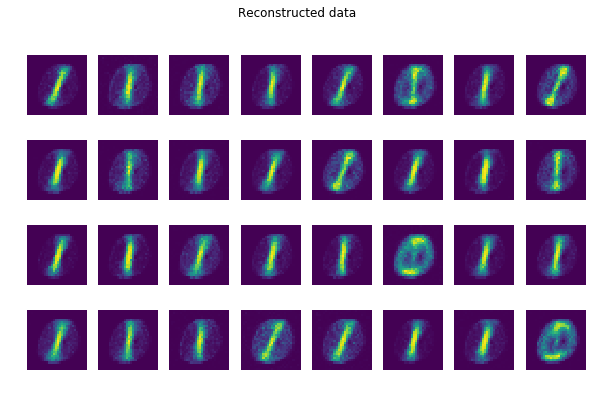

In [14]:
f, axarr = plt.subplots(4, 8, figsize=(10, 6))

input = Variable(images[50:].view(50, -1))
label = Variable(labels[50:].view(50, 1).type(torch.FloatTensor))
x, *_ = model(input, label)

plt.suptitle("Reconstructed data")

for i in range(batch_size):
    ims = x.data.numpy().reshape(-1, 28, 28)
    axarr[i//8, i%8].imshow(ims[i])
    axarr[i//8, i%8].axis("off")

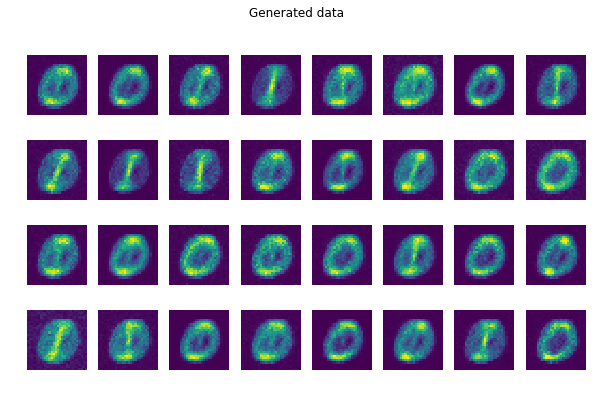

In [18]:
f, axarr = plt.subplots(4, 8, figsize=(10, 6))

z = torch.randn(batch_size, 32)
label = generate_label(batch_size, 1)

input = (Variable(z), Variable(label))
generated = model.generate(*input)

plt.suptitle("Generated data")

for i in range(batch_size):
    ims = generated.data.numpy().reshape(-1, 28, 28)
    axarr[i//8, i%8].imshow(ims[i])
    axarr[i//8, i%8].axis("off")